In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np

In [2]:
df = pd.read_csv('spoiler_balanced.csv')

In [3]:
df.head()

,review_text,is_spoiler,clean_review
0,"In its Oscar year, Shawshank Redemption (writt...",True,oscar year shawshank redemption written direct...
1,The Shawshank Redemption is without a doubt on...,True,shawshank redemption without doubt one brillia...
2,I believe that this film is the best story eve...,True,believe film best story ever told film im tell...
3,"**Yes, there are SPOILERS here**This film has ...",True,yes spoiler herethis film emotional impact fin...
4,At the heart of this extraordinary movie is a ...,True,heart extraordinary movie brilliant indelible ...


In [4]:
# Check data info (types, non-null counts)
print("\nDataFrame info:")
print(df.info())


DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573913 entries, 0 to 573912
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   review_text   573913 non-null  object
 1   is_spoiler    573913 non-null  bool  
 2   clean_review  573913 non-null  object
dtypes: bool(1), object(2)
memory usage: 9.3+ MB
None


In [4]:
df.nunique()


review_text     573385
is_spoiler           2
clean_review    573249
dtype: int64

In [5]:
df = df[['is_spoiler', 'clean_review']]   # keep only the 2 columns
df = df.drop_duplicates(subset='clean_review')  # drop duplicates based on clean_review

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 573249 entries, 0 to 573912
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   is_spoiler    573249 non-null  bool  
 1   clean_review  573249 non-null  object
dtypes: bool(1), object(1)
memory usage: 9.3+ MB


In [7]:
# Check distribution of spoiler labels
print("\nDistribution of 'is_spoiler':")
print(df['is_spoiler'].value_counts())


Distribution of 'is_spoiler':
is_spoiler
False    422404
True     150845
Name: count, dtype: int64


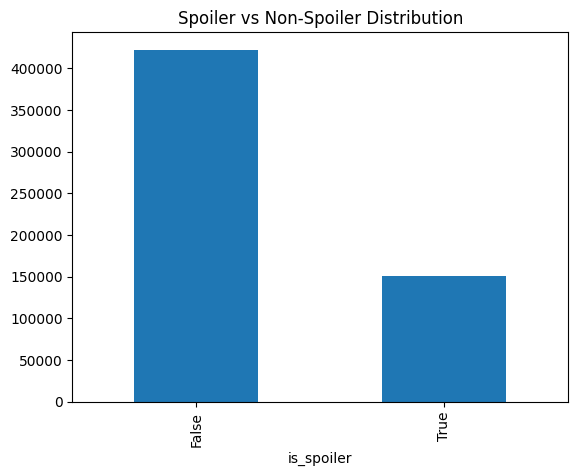

In [8]:
# Plot the distribution of spoilers vs non-spoilers
df['is_spoiler'].value_counts().plot(kind='bar', title='Spoiler vs Non-Spoiler Distribution')
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Parameters
desired_ratio = 0.6  # False : True
min_words = 5        # Minimum words per review
random_state = 42
val_test_ratio = 0.15  # 15% validation, 15% test

# Filter short reviews
df = df[df['clean_review'].str.split().str.len() >= min_words]
print(f"Dataset size after filtering short reviews: {len(df)}")

# Separate classes
df_true = df[df['is_spoiler'] == True]
df_false = df[df['is_spoiler'] == False]

# Random downsampling of False
n_true = len(df_true)
n_false_desired = int((desired_ratio / (1 - desired_ratio)) * n_true)
df_false_down = df_false.sample(n=n_false_desired, random_state=random_state)

# Combine True and downsampled False
df_balanced = pd.concat([df_true, df_false_down]).sample(frac=1, random_state=random_state)


Dataset size after filtering short reviews: 573204


In [ ]:
# Split into train / val / test
train_df, temp_df = train_test_split(
    df_balanced,
    test_size=2*val_test_ratio,  # Remaining 30% split equally
    stratify=df_balanced['is_spoiler'],
    random_state=random_state
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['is_spoiler'],
    random_state=random_state
)


# Print info
def print_counts(df, name):
    true_count = df['is_spoiler'].sum()
    false_count = (~df['is_spoiler']).sum()
    ratio_false = false_count / (true_count + false_count)
    ratio_true = true_count / (true_count + false_count)
    print(f"{name} set:")
    print(f"  True:  {true_count}")
    print(f"  False: {false_count}")
    print(f"  Ratio (False:True): {ratio_false:.2f} : {ratio_true:.2f}\n")

print_counts(train_df, "Training")
print_counts(val_df, "Validation")
print_counts(test_df, "Test")

Training set:
  True:  105589
  False: 158383
  Ratio (False:True): 0.60 : 0.40

Validation set:
  True:  22627
  False: 33939
  Ratio (False:True): 0.60 : 0.40

Test set:
  True:  22626
  False: 33940
  Ratio (False:True): 0.60 : 0.40



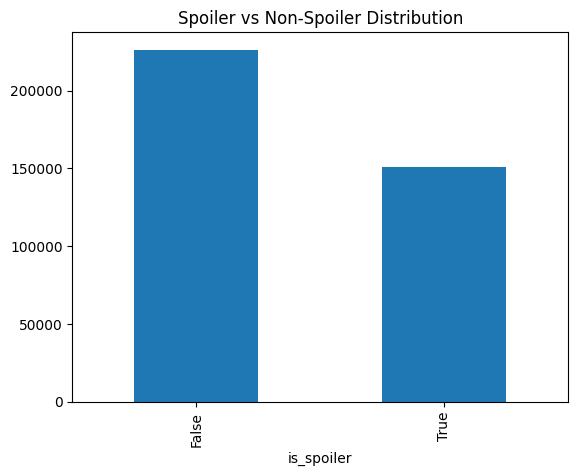

In [11]:
# Plot the distribution of spoilers vs non-spoilers
df_balanced['is_spoiler'].value_counts().plot(kind='bar', title='Spoiler vs Non-Spoiler Distribution')
plt.show()

In [12]:
from collections import Counter
import numpy as np

# Flatten all words into a single list
all_words = " ".join(train_df['clean_review']).split()

# Count word frequencies
word_counts = Counter(all_words)

# Sort by frequency (most common first)
sorted_words = word_counts.most_common()

# Total number of tokens
total_tokens = sum(word_counts.values())

# Function to find vocab size that covers a percentage of tokens
def vocab_size_for_coverage(coverage=0.95):
    cumulative = 0
    vocab_size = 0
    for word, count in sorted_words:
        cumulative += count
        vocab_size += 1
        if cumulative / total_tokens >= coverage:
            break
    return vocab_size

# Example: coverage for 90%, 95%, 99%
for cov in [0.90, 0.95, 0.99]:
    size = vocab_size_for_coverage(cov)
    print(f"To cover {int(cov*100)}% of the dataset, you need ~{size} words.")


To cover 90% of the dataset, you need ~8984 words.
To cover 95% of the dataset, you need ~20481 words.
To cover 99% of the dataset, you need ~263526 words.


In [ ]:
from transformers import AutoTokenizer
import pandas as pd

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Example: token lengths for clean_review
token_lens = []
for txt in df_balanced["clean_review"]:
    tokens = tokenizer.encode(txt, add_special_tokens=True)
    token_lens.append(len(tokens))

df_lengths = pd.Series(token_lens)

print("Max token length:", df_lengths.max())
print(df_lengths.describe())


In [17]:
import numpy as np

max_len_90 = int(np.percentile(df_lengths, 90))
max_len_95 = int(np.percentile(df_lengths, 95))

print(f"90% coverage: {max_len_90} tokens")
print(f"95% coverage: {max_len_95} tokens")


90% coverage: 353 tokens
95% coverage: 459 tokens


In [14]:
# Fit tokenizer on the training set
tokenizer = Tokenizer(num_words=20000, oov_token="<UNK>")
tokenizer.fit_on_texts(train_df['clean_review'])

# Convert text to sequences - Converts each review into a list of integers based on the tokenizer’s vocabulary
x_train = tokenizer.texts_to_sequences(train_df['clean_review'])
x_val = tokenizer.texts_to_sequences(val_df['clean_review'])
x_test = tokenizer.texts_to_sequences(test_df['clean_review'])

# Pad sequences
max_len = 459   
x_train = pad_sequences(x_train, maxlen=max_len, padding='post', truncating='post')
x_val = pad_sequences(x_val, maxlen=max_len, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_len, padding='post', truncating='post')

# Prepare targets
'''
Converts labels (True/False or 0/1) to integer NumPy arrays for use in training.
.astype(int): Ensures the data is in numeric format.
.values: Converts pandas Series to NumPy array.
'''
y_train = train_df['is_spoiler'].astype(int).values
y_val = val_df['is_spoiler'].astype(int).values
y_test = test_df['is_spoiler'].astype(int).values

In [15]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Class weights for training:", class_weight_dict)

Class weights for training: {np.int64(0): np.float64(0.8333343856348219), np.int64(1): np.float64(1.249997632329125)}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras import regularizers

vocab_size = 20000   # Size of vocabulary (top 10,000 words)
embedding_dim = 100  # Size of word embedding vectors
max_len = 459        # Max length of each input sequence

# L2 regularization strength
l2_reg = 1e-4

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),

    Bidirectional(LSTM(
        64,
        kernel_regularizer=regularizers.l2(l2_reg),  # L2 on weights
        recurrent_regularizer=regularizers.l2(l2_reg),  # L2 on recurrent connections
        bias_regularizer=regularizers.l2(l2_reg)  # L2 on biases 
    )),

    Dropout(0.5),

    Dense(
        64,
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_reg),
        bias_regularizer=regularizers.l2(l2_reg)
    ),

    Dropout(0.5),

    Dense(
        1,
        activation='sigmoid',
        kernel_regularizer=regularizers.l2(l2_reg),
        bias_regularizer=regularizers.l2(l2_reg)
    )
])

model.build(input_shape=(None, max_len))


c:\Users\Madhumita\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [17]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 459, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,092,801 (7.98 MB)

 Trainable params: 2,092,801 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

None


In [18]:
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),  
    metrics=['accuracy']
)

In [19]:
checkpoint_callback = ModelCheckpoint(
    filepath="checkpoints_final1/model_epoch_{epoch:02d}.weights.h5",
    save_weights_only=True,
    save_freq='epoch', #Save the weights after every epoch.
    verbose=1 #Keras will print a message whenever a model is saved.
)

In [20]:
import math

num_train_samples = len(x_train)
batch_size = 512
steps_per_epoch = math.ceil(num_train_samples / batch_size) #calculates how many batches (steps) are needed to go through the entire training dataset once, i.e., one full epoch.

In [21]:
# Train for a small number of epochs (e.g. 2) initially
initial_epoch = 0
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=2,
    initial_epoch=initial_epoch,
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    class_weight=class_weight_dict,
    callbacks=[checkpoint_callback]
)

Epoch 1/2
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6267 - loss: 0.6667
Epoch 1: saving model to checkpoints_final1/model_epoch_01.weights.h5
516/516 ━━━━━━━━━━━━━━━━━━━━ 5346s 10s/step - accuracy: 0.6665 - loss: 0.6305 - val_accuracy: 0.7082 - val_loss: 0.5832
Epoch 2/2
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7134 - loss: 0.5728 
Epoch 2: saving model to checkpoints_final1/model_epoch_02.weights.h5
516/516 ━━━━━━━━━━━━━━━━━━━━ 5643s 11s/step - accuracy: 0.7115 - loss: 0.5734 - val_accuracy: 0.7147 - val_loss: 0.5676


In [22]:
# Later, resume training from epoch 2
model.load_weights("checkpoints_final1/model_epoch_02.weights.h5")

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=5,             
    initial_epoch=2,      
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    class_weight=class_weight_dict,
    callbacks=[checkpoint_callback]
)


Epoch 3/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7304 - loss: 0.5460
Epoch 3: saving model to checkpoints_final1/model_epoch_03.weights.h5
516/516 ━━━━━━━━━━━━━━━━━━━━ 5097s 10s/step - accuracy: 0.7282 - loss: 0.5492 - val_accuracy: 0.6986 - val_loss: 0.6004
Epoch 4/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7477 - loss: 0.5205
Epoch 4: saving model to checkpoints_final1/model_epoch_04.weights.h5
516/516 ━━━━━━━━━━━━━━━━━━━━ 5246s 10s/step - accuracy: 0.7412 - loss: 0.5287 - val_accuracy: 0.6832 - val_loss: 0.5992
Epoch 5/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7584 - loss: 0.5032
Epoch 5: saving model to checkpoints_final1/model_epoch_05.weights.h5
516/516 ━━━━━━━━━━━━━━━━━━━━ 5343s 10s/step - accuracy: 0.7525 - loss: 0.5126 - val_accuracy: 0.7015 - val_loss: 0.5873


In [23]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test, batch_size=512)
2
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

111/111 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.7012 - loss: 0.5894
Test Loss: 0.5894
Test Accuracy: 0.7012


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predict probabilities
y_pred_prob = model.predict(x_test)

# Convert probabilities to class labels (0/1) using 0.5 threshold
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()

# Accuracy
acc = accuracy_score(y_test, y_pred)

# Precision
prec = precision_score(y_test, y_pred)

# Recall
rec = recall_score(y_test, y_pred)

# F1-score
f1 = f1_score(y_test, y_pred)

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Print metrics
print(f"Test Accuracy : {acc:.4f}")
print(f"Precision     : {prec:.4f}")
print(f"Recall        : {rec:.4f}")
print(f"F1-Score      : {f1:.4f}")
print(f"ROC-AUC       : {roc_auc:.4f}")

1768/1768 ━━━━━━━━━━━━━━━━━━━━ 208s 117ms/step
Test Accuracy : 0.7012
Precision     : 0.6314
Recall        : 0.6082
F1-Score      : 0.6196
ROC-AUC       : 0.7572


In [43]:
print("Predicted class counts:", np.bincount(y_pred))
print("Actual class counts   :", np.bincount(y_test))

Predicted class counts: [68896 29173]
Actual class counts   : [98069]


In [25]:
model.save('spoiler_pred_finalcopy.h5')  # Saves in HDF5 format

In [26]:
import pickle
with open("tokenizer_final.pkl", "wb") as f:
    pickle.dump(tokenizer, f)